### <span style="color:olive">Data Science Project</span> 
# Build an Efficient Word Translator

#### Part I - Build a learning a linear supervised mapping from a source (french) to a target (english)
#### Part II - Build an unsupervised translator using Generative Adversarial Network (GAN)
***

In [41]:
import io
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import math
from statistics import stdev
from tqdm import tqdm

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

from scipy.stats import special_ortho_group
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

In [42]:
# load function for pretrained versions of word embeddings
def load_embeddings(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [43]:
current_path = os.getcwd()
eng_path = current_path + '/Monolingual/wiki.en.vec' 
fr_path = current_path + '/Monolingual/wiki.fr.vec'

nmax = 50000  # maximum number of word embeddings to load

# load monolingual word embeddings 
src_embeddings, src_id2word, src_word2id = load_embeddings(fr_path, nmax) # source = french 
tgt_embeddings, tgt_id2word, tgt_word2id = load_embeddings(eng_path, nmax) # target = english

### FRENCH to ENGLISH translation

* source language = french
* target language = english
***

In [44]:
# load ground-truth bilingual dictionaries function
def load_dic(path):
    dico_full = {}
    vectors_src=[]
    vectors_tgt = []
    with io.open(path,'r',encoding='utf_8') as f:
        for i,line in enumerate(f):
            word_src, word_tgt = line.rstrip().split(' ',1)
            if word_tgt in tgt_word2id :
                dico_full[word_src]=word_tgt
    for key in dico_full.keys() :
            vectors_src.append(src_embeddings[src_word2id[key]])
            vectors_tgt.append(tgt_embeddings[tgt_word2id[dico_full[key]]])
    X = np.vstack(vectors_src)
    Z = np.vstack (vectors_tgt)
    return dico_full,X,Z

In [45]:
# train & test bilingual dictionaries
path_train = current_path + '/Monolingual/fr-en.0-5000.txt' 
path_test = current_path + '/Monolingual/fr-en.5000-6500.txt'
dico_train, X_train, Z_train = load_dic(path_train)
dico_test, X_test, Z_test = load_dic(path_test) 

## Part I - Build a learning a linear mapping from a source (french) to a target (english) embedding space thanks to a translation Matrix W 

Based on : "Exploiting Similarities among Languages for Machine Translation" of Tomas Mikolov, Quoc V. Le & Ilya Sutskever (2013)

Suppose we are given a set of word pairs and their associated vector representations ${ \{x_i , z_i\} }^{n}_{i=1}$ , where $x_i$ ∈ $R^{d1}$ is the distributed representation of word i in the source language, and $z_i$ ∈ $R^{d2}$ is the vector representation of its translation.

It is our goal to find a transformation matrix W such that W xi approximates $z_i$ . In practice, W can be learned by the following optimization problem :

$$ \underset{W}{min} C (W) = \underset{W}{min} \sum_{i=1}^{n} \| W x_i - z_i \|^2 $$ 

which we solve with gradient descent (GD), stochastic gradient descent (SGD) or mini-batch gradient descent (BGD).

In [46]:
print(X_train.shape[0], "training samples")
print(X_test.shape[0], "test samples")

print("d1 dimension :", X_train.shape[1])
print("d2 dimension :", X_test.shape[1])

4971 training samples
1483 test samples
d1 dimension : 300
d2 dimension : 300


In [47]:
# function to minimize 
# normalisation added
def C(W,X,Z):
    S = 0
    S = sum(np.linalg.norm(np.dot(X, W.T) - Z, axis=1)**2) 
    return S

In [48]:
# gradient of the function to minimize
# normalisation added
def GradW(W,X,Z):
    G = np.zeros((Z_train.shape[1], X_train.shape[1]))
    G = 2*np.dot(X.T, (np.dot(X, W.T) - Z)).T
    return G

In [49]:
# GD function
def GradientDescent(eta, niter): 
    W = np.random.rand(Z_train.shape[1],Z_train.shape[1]) # random initialisation of W
    value_C = np.zeros(niter)
    
    for t in range(niter): 
        value_C[t] = (1/(X_train.shape[0])) * C(W,X_train,Z_train)
        W -= (1/X_train.shape[0])*eta*GradW(W,X_train,Z_train)
    print("GD done...")
    return (W, value_C) #,acc_test,acc_train)

In [50]:
# SGD function
def StochasticGradientDescent(eta, niter):
    W = np.random.rand(Z_train.shape[1],Z_train.shape[1]) # random initialisation of W
    grad = np.zeros((Z_train.shape[1], X_train.shape[1]))
    value_C = np.zeros(niter)
    
    for t in range(niter):
        rand_ind = np.random.randint(0, X_train.shape[0]) 
        X_i = X_train[rand_ind,:]
        Z_i = Z_train[rand_ind,:]    
        W -= eta*2*np.outer(X_i.T, (np.dot(X_i, W.T) - Z_i)).T   
        value_C[t] = np.linalg.norm(np.dot(W, X_i) - Z_i)**2
    print("SGD done...")
    return (W, value_C)

In [51]:
# BGD function
def BatchGradientDescent(eta, niter, batch_size):
    # initialisation
    N = X_train.shape[0]
    W = np.random.rand(Z_train.shape[1],Z_train.shape[1]) # random initialisation of W
    value_C = np.zeros(niter)
    for t in range(niter):
        l = np.random.choice(N,batch_size)
        grad = np.random.rand(Z_train.shape[1],Z_train.shape[1])
        cost = 0 
        for i in l:
            cost += np.linalg.norm(np.dot(W, X_train[i]) - Z_train[i])**2
            grad += 2*np.outer((np.dot(W, X_train[i]) - Z_train[i]), X_train[i])
        value_C[t] = (1/(batch_size)) * cost
        W -= eta*(1/(batch_size))*grad
    print("MGD done...")
    return (W, value_C)

### Train the model
The goal is to find the best W to map the source language to the target one.

In [52]:
eta_GD = 0.3
eta_SGD = 0.01
eta_BGD = 0.1
niter = 200

W_GD, C_GD = GradientDescent(eta_GD, niter) # GD
W_SGD, C_SGD = StochasticGradientDescent(eta_SGD, 2000) # SGD
W_BGD, C_BGD = BatchGradientDescent(eta_BGD, niter, 20) # BGD

GD done...
SGD done...
MGD done...


In [99]:
print(C_SGD.shape)
print(C_GD.shape)

(10000,)
(100,)


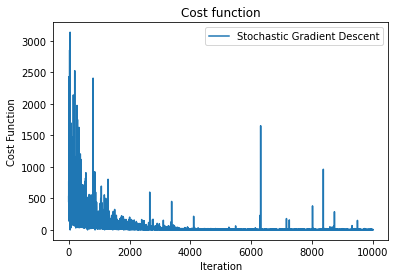

In [108]:
#plt.plot(C_GD, label="Gradient Descent")
plt.plot(C_SGD, label="Stochastic Gradient Descent")
#plt.plot(range(niter), C_BGD, label="Batch Gradient Descent")
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
plt.title("Cost function")
plt.legend()
plt.show()

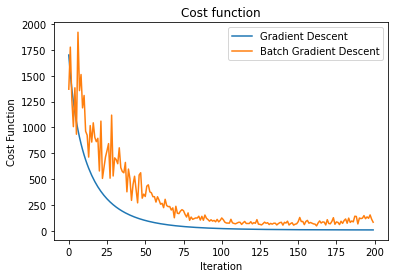

In [54]:
plt.plot(range(niter), C_GD, label="Gradient Descent")
#plt.plot(range(niter), C_SGD, label="Stochastic Gradient Descent")
plt.plot(range(niter), C_BGD, label="Batch Gradient Descent")
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
plt.title("Cost function")
plt.legend()
plt.show()


In [55]:
# Fastest training
Wmin = np.dot(np.linalg.pinv(X_train), Z_train).T 

### Testing the model

At the prediction time, for any given new word and its continuous vector representation x, we can map it to the other language space by computing $z = Wx$. Then, we find the word whose representation is closest to z in the target language space, using cosine similarity as the distance metric.

In [56]:
def prediction(W, new_word, k=5):
    x = src_embeddings[src_word2id[new_word]] # vector representation of new_word in the source space
    z = np.dot(W, x) # vector representation of the translated word in the target space

    # representation closest to z in the target language space, using cosine similarity as the distance metric
    z_pred1 = np.argmax(cosine_similarity(z.reshape(1,300),tgt_embeddings))

    # top k closest word embeddings in the target space
    z_predk = cosine_similarity(z.reshape(1,300),tgt_embeddings)[0].argsort()[-k:][::-1]
    
    return [tgt_id2word[z_pred1]], [tgt_id2word[z_predk[i]] for i in range(len(z_predk))]  # return the id of the translated word

In [57]:
# just a litte test
top1, top5 = prediction(W_GD, "bateau", k=5)
print("Top 1 translation for 'bateau' is :", top1)
print("Top 5 translations for 'bateau' are :", top5)

Top 1 translation for 'bateau' is : ['boat']
Top 5 translations for 'bateau' are : ['boat', 'boats', 'steamer', 'sailing', 'vessel']


In [58]:
# construct a translation French to English dictionary
def prediction_dict(dico, W, kk):
    dico_pred1 = {}
    dico_predk = {}
    for word in tqdm(dico.keys()):
        dico_pred1[word], dico_predk[word] = prediction(W, word, k) # lists
    print("Done...")
    return dico_pred1, dico_predk

In [59]:
# test predictions for W from GD

# k-top accuracy ("acc@k")
k = 5

dico_pred1, dico_predk = prediction_dict(dico_test, W_GD, k) 
dico_pred1_best, dico_predk_best = prediction_dict(dico_test, Wmin, k) 

  0%|          | 1/1483 [00:00<03:50,  6.43it/s]

Done...


100%|██████████| 1483/1483 [03:42<00:00,  6.66it/s]

Done...


In [60]:
# measure of the accuracy of the dictionnary
# output is a list
def accuracy(dpred1, dpredk, dico):
    acc1 = [0]
    acck = [0]
    
    for key in dico.keys():
        add1, addk = 0, 0
        
        if dico[key] == dpred1[key][0]:
            add1 = 1
        acc1.append(acc1[-1] + add1)  
    
        for i in np.arange(k):
            if dico[key] == dpredk[key][i]:
                addk = 1
                break   
        acck.append(acck[-1] + addk) 
    
    acc1 = [i/len(dico) for i in acc1]   
    acck = [i/len(dico) for i in acck]
    
    return acc1, acck # nb de mots bien prédits/nb de mots total     

In [61]:
acc1_test, acck_test = accuracy(dico_pred1, dico_predk, dico_test)
acc1_test_best, acck_test_best = accuracy(dico_pred1_best, dico_predk_best, dico_test)

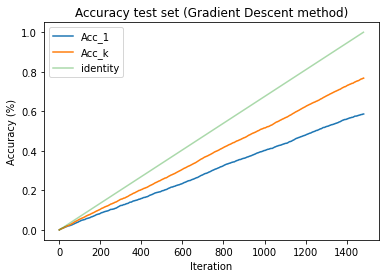

Gradient descent method :
Final accuracy @1 = 58.6 %
Final accuracy @5 = 76.74 %

Analytical method :
Final accuracy @1 = 60.22 %
Final accuracy @5 = 77.14 %


In [62]:
plt.plot(acc1_test, label="Acc_1")
plt.plot(acck_test,label="Acc_k")
plt.plot([i/len(dico_test) for i in range(len(dico_test))],label="identity",alpha=0.4)
plt.ylabel('Accuracy (%)')
plt.xlabel('Iteration')
plt.title("Accuracy test set (Gradient Descent method)")
plt.legend()
plt.show()

print("Gradient descent method :")
print("Final accuracy @1 =", round(acc1_test[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test[-1]*100, 2), "%")
print("")
print("Analytical method :")
print("Final accuracy @1 =", round(acc1_test_best[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test_best[-1]*100, 2), "%")

### Annex part I

GD done...
GD done...
GD done...
GD done...
GD done...
GD done...


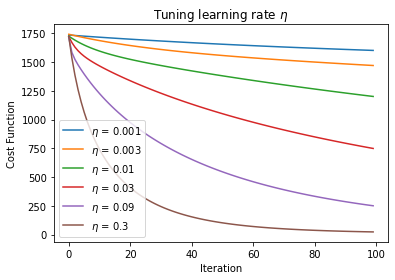

In [63]:
# GD hyper parameter sensitivity 
eta_list = np.array([0.001, 0.003, 0.01, 0.03, 0.09, 0.3]) 
niter = 100

plt.clf

for ieta in np.arange(0,eta_list.size):
    eta = eta_list[ieta]
    W_GD, C_GD = GradientDescent(eta, niter)
    plt.plot(C_GD, label='$\eta$ = %s' % eta_list[ieta])
    
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
plt.title("Tuning learning rate $\eta$")
plt.legend()

plt.show()

SGD done...
SGD done...
SGD done...


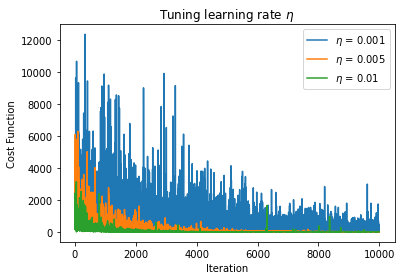

In [64]:
# SGD hyper parameter sensitivity 
eta_list = np.array([0.001, 0.005, 0.01])  #0.09, 0.3,0.03, 
niter = 10000

plt.clf

for ieta in np.arange(0,eta_list.size):
    eta = eta_list[ieta]
    W_SGD, C_SGD = StochasticGradientDescent(eta, niter)
    plt.plot(C_SGD, label='$\eta$ = %s' % eta_list[ieta])
    
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
plt.title("Tuning learning rate $\eta$")
plt.legend()

plt.show()

MGD done...
MGD done...
MGD done...
MGD done...


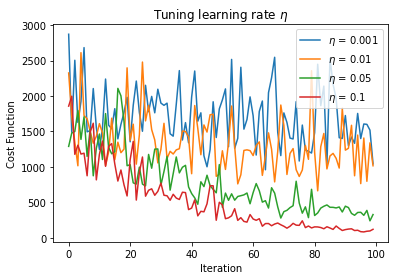

In [65]:
# BGD hyper parameter sensitivity
eta_list = np.array([0.001, 0.01, 0.05, 0.1])   
niter = 100
batch_size = 20

plt.clf

for ieta in np.arange(0,eta_list.size):
    eta = eta_list[ieta]
    W_BGD, C_BGD = BatchGradientDescent(eta, niter, batch_size)
    plt.plot(C_BGD, label='$\eta$ = %s' % eta_list[ieta])
    
plt.ylabel('Cost Function')
plt.xlabel('Iteration')
plt.title("Tuning learning rate $\eta$")
plt.legend()

plt.show()

In [66]:
def CVGradientDescent(eta, eps): 
    start_time = time.time()
    W = np.random.rand(Z_train.shape[1],Z_train.shape[1]) # random initialisation of W
    value_C = []
    cost = (1/(X_train.shape[0])) * C(W,X_train,Z_train)
    value_C.append(cost)
    n_iter = 0
    
    while cost > eps:       
        W -= (1/X_train.shape[0])*eta*GradW(W,X_train,Z_train)
        cost = (1/(X_train.shape[0])) * C(W,X_train,Z_train)
        value_C.append(cost)
        n_iter += 1
        if stdev(value_C[-10:]) < 0.1:
            break
    exe = time.time() - start_time
    print("GD done...")
    return (n_iter, exe) 

In [67]:
def CVStochasticGradientDescent(eta, eps): 
    start_time = time.time()
    W = np.random.rand(Z_train.shape[1],Z_train.shape[1]) # random initialisation of W
    grad = np.zeros((Z_train.shape[1], X_train.shape[1]))
    value_C = []
    cost = (1/(X_train.shape[0])) * C(W,X_train,Z_train)
    cost_prec = 0.0
    value_C.append(cost)
    n_iter = 0
    
    while (cost > eps) and (abs(cost - cost_prec) > 0.1) :   
        rand_ind = np.random.randint(0, X_train.shape[0]) 
        X_i = X_train[rand_ind,:]
        Z_i = Z_train[rand_ind,:]    
        W -= eta*2*np.outer(X_i.T, (np.dot(X_i, W.T) - Z_i)).T   
        cost = np.linalg.norm(np.dot(W, X_i) - Z_i)**2
        cost_prec = value_C[-1]
        value_C.append(cost)
        n_iter += 1
        if stdev(value_C[-250:]) < 0.1:
            break
    exe = time.time() - start_time
    print("SGD done...")
    return (n_iter, exe, value_C) 

In [68]:
def CVBatchGradientDescent(eta, eps, batch_size): 
    start_time = time.time()
    N = X_train.shape[0]
    W = np.random.rand(Z_train.shape[1],Z_train.shape[1]) # random initialisation of W
    value_C = []
    rand_ind = np.random.randint(0, X_train.shape[0])
    cost = np.linalg.norm(np.dot(W, X_train[rand_ind]) - Z_train[rand_ind])**2
    value_C.append(cost)
    n_iter = 0
    
    while (cost > eps): #& (abs(cost - cost_prec) > 10):     
        l = np.random.choice(N,batch_size)
        grad = np.random.rand(Z_train.shape[1],Z_train.shape[1])
        cost = 0
        for i in l:
            cost += np.linalg.norm(np.dot(W, X_train[i]) - Z_train[i])**2
            grad += 2*np.outer((np.dot(W, X_train[i]) - Z_train[i]), X_train[i])
        cost = (1/batch_size) * cost
        cost_prec = value_C[-1]
        value_C.append(cost)
        W -= eta*(1/(batch_size))*grad 
        n_iter += 1

        if stdev(value_C[-10:]) < 0.01:
            break
    exe = time.time() - start_time
    print("BGD done...")
    return (n_iter, exe) 

In [69]:
# attention pas la même borne de cv...
niter_GD, exe_GD = CVGradientDescent(eta_GD, 5)
niter_SGD, exe_SGD, CSGD = CVStochasticGradientDescent(eta_SGD, 1e-3)
niter_BGD, exe_BGD = CVBatchGradientDescent(eta_BGD, 70, 20)

GD done...
SGD done...
BGD done...


SGD done...


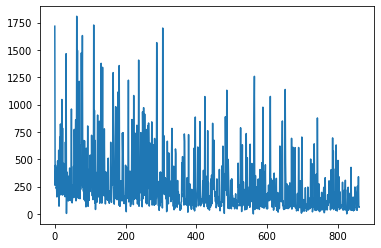

In [70]:
niter_SGD, exe_SGD, CC = CVStochasticGradientDescent(eta_SGD, 1e-3)
plt.plot(CC)

In [71]:
print("Temps d'éxécution jusqu'à cv :")
print(" GD : ", exe_GD, "s")
print(" SGD : ", exe_SGD, "s")
print(" BGD : ", exe_BGD, "s")
print("")
print("Temps d'éxécution / itération :")
print(" GD : ", (exe_GD*1e3)/niter_GD, "ms/ité")
print(" SGD : ", (exe_SGD*1e3)/niter_SGD, "ms/ité")
print(" BGD : ", (exe_BGD*1e3)/niter_BGD, "ms/ité")

Temps d'éxécution jusqu'à cv :
 GD :  6.37693977355957 s
 SGD :  1.288954257965088 s
 BGD :  0.5574820041656494 s

Temps d'éxécution / itération :
 GD :  34.65728137804114 ms/ité
 SGD :  1.498784020889637 ms/ité
 BGD :  5.360403886208167 ms/ité


In [72]:
# BGD function
def BatchGradientDescent(eta, niter, batch_size):
    # initialisation
    N = X_train.shape[0]
    W = np.random.rand(Z_train.shape[1],Z_train.shape[1]) # random initialisation of W
    value_C = np.zeros(niter)
    for t in range(niter):
        l = np.random.choice(N,batch_size)
        grad = np.random.rand(Z_train.shape[1],Z_train.shape[1])
        cost = 0 
        for i in l:
            cost += np.linalg.norm(np.dot(W, X_train[i]) - Z_train[i])**2
            grad += 2*np.outer((np.dot(W, X_train[i]) - Z_train[i]), X_train[i])
        value_C[t] = (1/(batch_size)) * cost
        W -= eta*(1/(batch_size))*grad
    print("MGD done...")
    return (W, value_C)

## Part II - Adressing the inconsistency

Based on : 
* "Normalized Word Embedding and Orthogonal Transform for Bilingual Word Translation" of Chao Xing, Dong Wang, Chao Liu & Yiye Lin (2015)

(Xing et al. (2015) argued that Mikolov’s linear matrix should be orthogonal, and introduced an
approximate procedure composed of gradient descent updates and repeated applications of the SVD)

* "Offline bilingual word vectors, orthogonal transformations and the inverted softmax" of Samuel L. Smith, David H. P. Turban, Steven Hamblin & Nils Y. Hammerla


**Intuition :**
A self-consistent linear transformation between vector
spaces should be orthogonal. Intuitively, the transformation is a rotation, and it is found using the
singular value decomposition (SVD). The SVD aligns the translations remarkably well.



If $W$ maps the source language into the target, then $W^T$ maps the target language back into the source. Then, the transformation $W$ should be an orthogonal matrix $O$ satisfying $O^T O = Id$


So, we still try to minimize the following optimisation problem :
$$ \underset{W \in O_d (\mathbb{R})}{argmin} \sum_{i=1}^{n} \| W x_i - z_i \|^2 $$ 

Except, this time $W$ should be also an orthogonal matrix $O$. The problem can be rewritten as finding the maximum of : 

$$ \underset{O}{max} \sum_{i=1}^{n} z_i^T O x_i $$ 
With the orthogonal constraint ($Id$ is the identity matrix) : $$ O^T O = Id $$

The cost function is minimize by : 
$$ O = U V^T $$ 
Where $U$ and $V$ are obtained from SVD of $Y^T X$

In [73]:
# perform SVD
U, Sg, V = np.linalg.svd(np.dot(Z_train.T, X_train), full_matrices=True)
# compute the orthogonal translation matrix
O = np.matmul(U, V)

In [74]:
# just a litte test
top1, top5 = prediction(O, "arbre", k=5)
print("Top 1 translation for 'bateau' is :", top1)
print("Top 5 translations for 'bateau' are :", top5)
print("Works great !")

Top 1 translation for 'bateau' is : ['tree']
Top 5 translations for 'bateau' are : ['tree', 'trees', 'understory', 'bushes', 'canopy']
Works great !


In [75]:
dico_pred1_o, dico_predk_o = prediction_dict(dico_test, O, k) 

100%|██████████| 1483/1483 [03:40<00:00,  6.74it/s]

Done...


In [76]:
acc1_test_o, acck_test_o = accuracy(dico_pred1_o, dico_predk_o, dico_test)

In [77]:
print("Gradient descent method :")
print("Final accuracy @1 =", round(acc1_test[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test[-1]*100, 2), "%")
print("")
print("Orthogonal method :")
print("Final accuracy @1 =", round(acc1_test_o[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test_o[-1]*100, 2), "%")
print("")
print("Analytical method :")
print("Final accuracy @1 =", round(acc1_test_best[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test_best[-1]*100, 2), "%")

Gradient descent method :
Final accuracy @1 = 58.6 %
Final accuracy @5 = 76.74 %

Orthogonal method :
Final accuracy @1 = 62.58 %
Final accuracy @5 = 78.96 %

Analytical method :
Final accuracy @1 = 60.22 %
Final accuracy @5 = 77.14 %


### PCA: Principal Component Analysis

For 2D representation of space alignment

In [78]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space with Translation matrix')

    plt.show()

Variance explained: 0.10


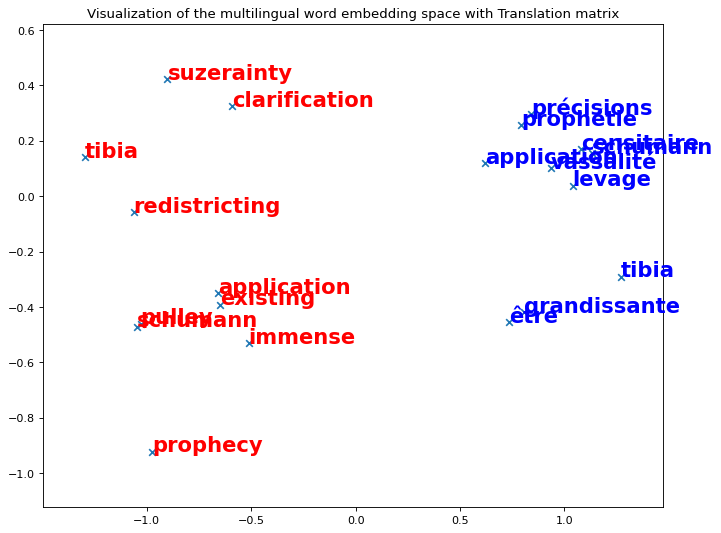

In [81]:
import random
src_words = random.sample(list(src_word2id.keys()), 10)
#src_words = ['bateau', 'maison', 'argent', 'ordinateur', 'dieu']
tgt_words = []
for i in range(0,len(src_words)):
    top1, top5 = prediction(W_GD, src_words[i], k=5) #top 1: english word (target)
    tgt_words.append(top1[0])

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)

## Part II - Build an unsupervised translator using Generative Adversarial Network (GAN)

The core idea of a GAN is based on the "indirect" training through the discriminator, which itself is also being updated dynamically. This basically means that the generator is not trained to minimize the distance to a specific word translation, but rather to fool the discriminator. This enables the model to learn in an unsupervised manner.

### Build the discriminator 

In [84]:
class Discriminator(nn.Module):
    def __init__(self, dim):
        super(Discriminator,self).__init__()
        self.h1 = nn.Linear(dim, 2048,bias=True) # 1st hidden layer
        self.h2 = nn.Linear(2048,2048,bias=True) # 2nd hidden layer
        self.out = nn.Linear(2048,1,bias=True) # output layer
        
    def forward(self, x):
        x = F.dropout(x, p = 0.1) # dropout pour ajouter du bruit
        x = F.leaky_relu(self.h1(x), negative_slope=0.2)
        x = F.leaky_relu(self.h2(x), negative_slope=0.2)
        y = torch.sigmoid(self.out(x)) # ouput = proba
        return y

### Build the generator 

In [85]:
# simple linear function 
# can be seen at a neural network whose weights are elements of W 
class Generator(nn.Module):
    def __init__(self, dim):
        super(Generator, self).__init__()
        self.l1 = nn.Linear(dim, dim, bias=False)

    def forward(self,x):
        y = self.l1(x)
        return y

## It's time to train 

In [86]:
dim = 300
discrim = Discriminator(dim)
gener = Generator(dim)

In [87]:
# Initialize BCELoss function
criterion = nn.BCELoss()

optimizerD = optim.SGD(discrim.parameters(), lr=0.1)
optimizerG = optim.SGD(gener.parameters(), lr=0.1)

In [88]:
#for epoch in range(3): #3 Epochs 
G_losses = []
D_losses = []
iters = 0

N = 16 # nb of "fake" tgt // Wx
M = 16 # nb of "true" tgt // y

W = special_ortho_group.rvs(dim) #np.zeros((300,300), dtype=float)  #np.random.rand(Z_train.shape[1],Z_train.shape[1]) #  # #
gener.l1.weight.data = torch.tensor(W,dtype=torch.float) # ini of generator's weights in SO(300)
beta = 0.01

for param in discrim.h1.parameters():
    param.data.normal_(0.0, 0.2) #uniform_(-0.1,0.1)

niter = 1000
num_epochs = 5
#nb_d = 1
#nb_g = 10

# Establish convention for real and fake labels during training
real_label = 0.8
fake_label = 0.2

In [92]:
num_epochs = 2
niter = 50000

In [93]:
print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i in range(niter):
        
        ###############################################################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))) #
        ###############################################################
        
        ## Train with all-real batch
        discrim.zero_grad()
        # Format batch : generate M random words from the target
        
        rand_tgt_word_id = torch.Tensor(M).random_(X_train.shape[0]).long()
        tgt_word_emb = Z_train[rand_tgt_word_id.numpy()]
        tgt_word_emb = torch.tensor(tgt_word_emb, dtype=torch.float) # conversion to tensor

        label = torch.full((M,1), real_label)
        
        # Forward pass real batch through D
        output = discrim(tgt_word_emb)#.view(-1)
        #print(output.shape)
        #print(output.view(-1).shape)
        
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        
        ## create a new batch of N fake & M true data to train the discriminator
        # generate N random words from the source 
        rand_src_word_id = torch.Tensor(N).random_(X_train.shape[0]).long()
        src_word_emb = X_train[rand_src_word_id.numpy()]
        noise = torch.tensor(src_word_emb, dtype=torch.float) # conversion to tensor
        
        # Generate fake tgt batch with G
        fake = gener(noise)
        
        label.fill_(fake_label)  
        # Classify all fake batch with D
        output = discrim(fake.detach())#.view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gener.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discrim(fake)#.view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()

        # Update G
        optimizerG.step()
        
        W_trained = gener.l1.weight.data # get the weights of the generator which are the elements of W
        # to ensure that the matrix stays close to the manifold of orthogonal matrices after each update
        W_ortho = (1+beta)*W_trained - beta*torch.mm(torch.mm(W_trained, W_trained.t()), W_trained) 
        gener.l1.weight.data = W_ortho 
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, niter,
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

Starting Training Loop...
[0/2][0/50000]	Loss_D: 1.0761	Loss_G: 1.8400	D(x): 0.8077	D(G(z)): 0.3171 / 0.1105
[0/2][50/50000]	Loss_D: 1.0948	Loss_G: 1.8180	D(x): 0.7782	D(G(z)): 0.3406 / 0.1193
[0/2][100/50000]	Loss_D: 1.1498	Loss_G: 2.1073	D(x): 0.7517	D(G(z)): 0.3832 / 0.0892
[0/2][150/50000]	Loss_D: 1.1646	Loss_G: 1.0397	D(x): 0.6528	D(G(z)): 0.2100 / 0.3097
[0/2][200/50000]	Loss_D: 1.1223	Loss_G: 1.0726	D(x): 0.6414	D(G(z)): 0.2295 / 0.3019
[0/2][250/50000]	Loss_D: 1.1993	Loss_G: 2.5252	D(x): 0.8288	D(G(z)): 0.4744 / 0.0507
[0/2][300/50000]	Loss_D: 1.0980	Loss_G: 1.0838	D(x): 0.6808	D(G(z)): 0.2134 / 0.2934
[0/2][350/50000]	Loss_D: 1.3287	Loss_G: 0.7176	D(x): 0.5188	D(G(z)): 0.1038 / 0.5173
[0/2][400/50000]	Loss_D: 1.1693	Loss_G: 1.1480	D(x): 0.6409	D(G(z)): 0.2799 / 0.2637
[0/2][450/50000]	Loss_D: 1.0728	Loss_G: 1.3452	D(x): 0.7419	D(G(z)): 0.2613 / 0.2019
[0/2][500/50000]	Loss_D: 1.1567	Loss_G: 2.0246	D(x): 0.7243	D(G(z)): 0.3923 / 0.0923
[0/2][550/50000]	Loss_D: 1.1304	Loss_G: 1.

[0/2][4800/50000]	Loss_D: 1.0810	Loss_G: 1.7907	D(x): 0.7945	D(G(z)): 0.3310 / 0.1164
[0/2][4850/50000]	Loss_D: 1.0503	Loss_G: 1.2165	D(x): 0.7596	D(G(z)): 0.1896 / 0.2412
[0/2][4900/50000]	Loss_D: 1.0520	Loss_G: 1.1627	D(x): 0.7209	D(G(z)): 0.1915 / 0.2590
[0/2][4950/50000]	Loss_D: 1.0649	Loss_G: 1.7843	D(x): 0.7537	D(G(z)): 0.2811 / 0.1208
[0/2][5000/50000]	Loss_D: 1.1108	Loss_G: 1.7139	D(x): 0.8218	D(G(z)): 0.3329 / 0.1284
[0/2][5050/50000]	Loss_D: 1.0823	Loss_G: 1.1188	D(x): 0.7107	D(G(z)): 0.1896 / 0.2717
[0/2][5100/50000]	Loss_D: 1.1145	Loss_G: 2.9709	D(x): 0.7780	D(G(z)): 0.3230 / 0.0672
[0/2][5150/50000]	Loss_D: 1.1030	Loss_G: 2.9806	D(x): 0.7778	D(G(z)): 0.3485 / 0.0386
[0/2][5200/50000]	Loss_D: 1.0551	Loss_G: 1.5599	D(x): 0.7676	D(G(z)): 0.2635 / 0.1569
[0/2][5250/50000]	Loss_D: 1.0868	Loss_G: 1.3161	D(x): 0.7311	D(G(z)): 0.2265 / 0.2116
[0/2][5300/50000]	Loss_D: 1.0458	Loss_G: 1.1246	D(x): 0.7230	D(G(z)): 0.1752 / 0.2723
[0/2][5350/50000]	Loss_D: 1.0558	Loss_G: 1.3883	D(x): 

[0/2][9600/50000]	Loss_D: 1.0683	Loss_G: 2.1379	D(x): 0.8101	D(G(z)): 0.3265 / 0.0792
[0/2][9650/50000]	Loss_D: 1.0727	Loss_G: 1.1054	D(x): 0.7151	D(G(z)): 0.1885 / 0.2874
[0/2][9700/50000]	Loss_D: 1.0783	Loss_G: 1.8196	D(x): 0.7703	D(G(z)): 0.2681 / 0.1169
[0/2][9750/50000]	Loss_D: 1.0451	Loss_G: 1.7404	D(x): 0.7941	D(G(z)): 0.2585 / 0.1273
[0/2][9800/50000]	Loss_D: 1.0691	Loss_G: 1.5361	D(x): 0.8142	D(G(z)): 0.2530 / 0.1644
[0/2][9850/50000]	Loss_D: 1.0830	Loss_G: 1.8564	D(x): 0.7815	D(G(z)): 0.2867 / 0.1122
[0/2][9900/50000]	Loss_D: 1.0479	Loss_G: 1.6050	D(x): 0.7765	D(G(z)): 0.2613 / 0.1470
[0/2][9950/50000]	Loss_D: 1.0528	Loss_G: 1.0964	D(x): 0.7397	D(G(z)): 0.1898 / 0.2863
[0/2][10000/50000]	Loss_D: 1.1001	Loss_G: 1.2366	D(x): 0.6815	D(G(z)): 0.2650 / 0.2424
[0/2][10050/50000]	Loss_D: 1.0588	Loss_G: 1.5841	D(x): 0.8051	D(G(z)): 0.2509 / 0.1537
[0/2][10100/50000]	Loss_D: 1.0580	Loss_G: 1.2329	D(x): 0.7420	D(G(z)): 0.2052 / 0.2370
[0/2][10150/50000]	Loss_D: 1.0435	Loss_G: 1.4664	D(

[0/2][14350/50000]	Loss_D: 1.0418	Loss_G: 1.5540	D(x): 0.7913	D(G(z)): 0.2812 / 0.1580
[0/2][14400/50000]	Loss_D: 1.1216	Loss_G: 1.0212	D(x): 0.6825	D(G(z)): 0.1476 / 0.3221
[0/2][14450/50000]	Loss_D: 1.0703	Loss_G: 2.0217	D(x): 0.7918	D(G(z)): 0.3379 / 0.0917
[0/2][14500/50000]	Loss_D: 1.0577	Loss_G: 1.7357	D(x): 0.8305	D(G(z)): 0.2794 / 0.1302
[0/2][14550/50000]	Loss_D: 1.0366	Loss_G: 1.4363	D(x): 0.8207	D(G(z)): 0.2144 / 0.1774
[0/2][14600/50000]	Loss_D: 1.0557	Loss_G: 1.3914	D(x): 0.7494	D(G(z)): 0.2366 / 0.1917
[0/2][14650/50000]	Loss_D: 1.0511	Loss_G: 1.7604	D(x): 0.7958	D(G(z)): 0.2772 / 0.1339
[0/2][14700/50000]	Loss_D: 1.0486	Loss_G: 1.6472	D(x): 0.7783	D(G(z)): 0.2937 / 0.1372
[0/2][14750/50000]	Loss_D: 1.0546	Loss_G: 1.3713	D(x): 0.7373	D(G(z)): 0.2109 / 0.1988
[0/2][14800/50000]	Loss_D: 1.0275	Loss_G: 1.4705	D(x): 0.7800	D(G(z)): 0.2406 / 0.1730
[0/2][14850/50000]	Loss_D: 1.0742	Loss_G: 1.5225	D(x): 0.7517	D(G(z)): 0.2634 / 0.1617
[0/2][14900/50000]	Loss_D: 1.0297	Loss_G: 1

[0/2][19100/50000]	Loss_D: 1.0807	Loss_G: 1.7125	D(x): 0.7409	D(G(z)): 0.1758 / 0.1857
[0/2][19150/50000]	Loss_D: 1.0613	Loss_G: 1.6124	D(x): 0.7697	D(G(z)): 0.2597 / 0.1426
[0/2][19200/50000]	Loss_D: 1.0611	Loss_G: 1.5802	D(x): 0.7786	D(G(z)): 0.2759 / 0.1479
[0/2][19250/50000]	Loss_D: 1.0471	Loss_G: 1.1653	D(x): 0.7173	D(G(z)): 0.2247 / 0.2592
[0/2][19300/50000]	Loss_D: 1.0586	Loss_G: 1.4231	D(x): 0.7519	D(G(z)): 0.2285 / 0.1865
[0/2][19350/50000]	Loss_D: 1.0337	Loss_G: 1.3305	D(x): 0.7718	D(G(z)): 0.2230 / 0.2065
[0/2][19400/50000]	Loss_D: 1.0753	Loss_G: 1.6658	D(x): 0.8096	D(G(z)): 0.2753 / 0.1350
[0/2][19450/50000]	Loss_D: 1.0356	Loss_G: 1.0722	D(x): 0.7685	D(G(z)): 0.1810 / 0.2901
[0/2][19500/50000]	Loss_D: 1.0466	Loss_G: 1.6267	D(x): 0.7592	D(G(z)): 0.2577 / 0.1419
[0/2][19550/50000]	Loss_D: 1.0476	Loss_G: 1.7677	D(x): 0.8250	D(G(z)): 0.2875 / 0.1186
[0/2][19600/50000]	Loss_D: 1.0359	Loss_G: 1.2692	D(x): 0.7461	D(G(z)): 0.2125 / 0.2266
[0/2][19650/50000]	Loss_D: 1.0525	Loss_G: 1

[0/2][23850/50000]	Loss_D: 1.0543	Loss_G: 1.1524	D(x): 0.7288	D(G(z)): 0.1849 / 0.2667
[0/2][23900/50000]	Loss_D: 1.0856	Loss_G: 1.1813	D(x): 0.7066	D(G(z)): 0.2040 / 0.2593
[0/2][23950/50000]	Loss_D: 1.0869	Loss_G: 1.2049	D(x): 0.6955	D(G(z)): 0.1873 / 0.2518
[0/2][24000/50000]	Loss_D: 1.1177	Loss_G: 2.5105	D(x): 0.8059	D(G(z)): 0.3439 / 0.0616
[0/2][24050/50000]	Loss_D: 1.1388	Loss_G: 2.1309	D(x): 0.7353	D(G(z)): 0.3616 / 0.0873
[0/2][24100/50000]	Loss_D: 1.0610	Loss_G: 1.3113	D(x): 0.7407	D(G(z)): 0.2334 / 0.2176
[0/2][24150/50000]	Loss_D: 1.0910	Loss_G: 0.9389	D(x): 0.6780	D(G(z)): 0.1642 / 0.3532
[0/2][24200/50000]	Loss_D: 1.1037	Loss_G: 0.9819	D(x): 0.6449	D(G(z)): 0.1641 / 0.3402
[0/2][24250/50000]	Loss_D: 1.1152	Loss_G: 1.4653	D(x): 0.6776	D(G(z)): 0.2714 / 0.1847
[0/2][24300/50000]	Loss_D: 1.0857	Loss_G: 1.5533	D(x): 0.7390	D(G(z)): 0.2788 / 0.1589
[0/2][24350/50000]	Loss_D: 1.1301	Loss_G: 1.6236	D(x): 0.6718	D(G(z)): 0.2979 / 0.1588
[0/2][24400/50000]	Loss_D: 1.0924	Loss_G: 1

[0/2][28600/50000]	Loss_D: 1.0576	Loss_G: 1.4325	D(x): 0.7572	D(G(z)): 0.2405 / 0.1833
[0/2][28650/50000]	Loss_D: 1.0524	Loss_G: 1.5381	D(x): 0.7789	D(G(z)): 0.2501 / 0.1676
[0/2][28700/50000]	Loss_D: 1.0738	Loss_G: 1.4066	D(x): 0.7315	D(G(z)): 0.2358 / 0.1911
[0/2][28750/50000]	Loss_D: 1.0984	Loss_G: 1.2131	D(x): 0.7253	D(G(z)): 0.2239 / 0.2480
[0/2][28800/50000]	Loss_D: 1.0541	Loss_G: 1.2996	D(x): 0.7510	D(G(z)): 0.2130 / 0.2182
[0/2][28850/50000]	Loss_D: 1.0852	Loss_G: 1.2470	D(x): 0.7386	D(G(z)): 0.1760 / 0.2322
[0/2][28900/50000]	Loss_D: 1.1715	Loss_G: 2.0714	D(x): 0.7050	D(G(z)): 0.3326 / 0.0904
[0/2][28950/50000]	Loss_D: 1.0556	Loss_G: 1.3335	D(x): 0.7505	D(G(z)): 0.2350 / 0.2120
[0/2][29000/50000]	Loss_D: 1.0966	Loss_G: 1.4290	D(x): 0.6995	D(G(z)): 0.2335 / 0.1822
[0/2][29050/50000]	Loss_D: 1.0676	Loss_G: 1.5667	D(x): 0.7227	D(G(z)): 0.2683 / 0.1610
[0/2][29100/50000]	Loss_D: 1.0790	Loss_G: 1.7866	D(x): 0.7627	D(G(z)): 0.2864 / 0.1223
[0/2][29150/50000]	Loss_D: 1.0836	Loss_G: 1

[0/2][33350/50000]	Loss_D: 1.0808	Loss_G: 1.0707	D(x): 0.6976	D(G(z)): 0.1933 / 0.3056
[0/2][33400/50000]	Loss_D: 1.0707	Loss_G: 1.0618	D(x): 0.7797	D(G(z)): 0.1872 / 0.3741
[0/2][33450/50000]	Loss_D: 1.0670	Loss_G: 1.8638	D(x): 0.7465	D(G(z)): 0.3057 / 0.1098
[0/2][33500/50000]	Loss_D: 1.0482	Loss_G: 1.5704	D(x): 0.7720	D(G(z)): 0.2433 / 0.1549
[0/2][33550/50000]	Loss_D: 1.0791	Loss_G: 1.5603	D(x): 0.7783	D(G(z)): 0.2614 / 0.1511
[0/2][33600/50000]	Loss_D: 1.0500	Loss_G: 1.3959	D(x): 0.7871	D(G(z)): 0.2275 / 0.1875
[0/2][33650/50000]	Loss_D: 1.0745	Loss_G: 1.8470	D(x): 0.7956	D(G(z)): 0.3129 / 0.1058
[0/2][33700/50000]	Loss_D: 1.0871	Loss_G: 1.5957	D(x): 0.7931	D(G(z)): 0.2675 / 0.1542
[0/2][33750/50000]	Loss_D: 1.0780	Loss_G: 1.6650	D(x): 0.7899	D(G(z)): 0.3105 / 0.1372
[0/2][33800/50000]	Loss_D: 1.0481	Loss_G: 1.3453	D(x): 0.7610	D(G(z)): 0.2197 / 0.2057
[0/2][33850/50000]	Loss_D: 1.0381	Loss_G: 1.3681	D(x): 0.7421	D(G(z)): 0.2445 / 0.1987
[0/2][33900/50000]	Loss_D: 1.0540	Loss_G: 1

[0/2][38100/50000]	Loss_D: 1.0444	Loss_G: 1.6934	D(x): 0.8004	D(G(z)): 0.2685 / 0.1354
[0/2][38150/50000]	Loss_D: 1.0678	Loss_G: 1.7951	D(x): 0.7878	D(G(z)): 0.2675 / 0.1269
[0/2][38200/50000]	Loss_D: 1.0888	Loss_G: 1.2723	D(x): 0.7283	D(G(z)): 0.2289 / 0.2272
[0/2][38250/50000]	Loss_D: 1.0887	Loss_G: 1.3141	D(x): 0.7042	D(G(z)): 0.2235 / 0.2108
[0/2][38300/50000]	Loss_D: 1.0447	Loss_G: 1.2032	D(x): 0.7524	D(G(z)): 0.1837 / 0.2427
[0/2][38350/50000]	Loss_D: 1.0448	Loss_G: 1.3834	D(x): 0.7771	D(G(z)): 0.2160 / 0.1915
[0/2][38400/50000]	Loss_D: 1.0748	Loss_G: 1.5885	D(x): 0.7531	D(G(z)): 0.2664 / 0.1479
[0/2][38450/50000]	Loss_D: 1.0481	Loss_G: 1.4445	D(x): 0.7627	D(G(z)): 0.2433 / 0.1848
[0/2][38500/50000]	Loss_D: 1.0673	Loss_G: 2.2689	D(x): 0.8118	D(G(z)): 0.2980 / 0.0866
[0/2][38550/50000]	Loss_D: 1.1133	Loss_G: 1.7057	D(x): 0.7609	D(G(z)): 0.3128 / 0.1305
[0/2][38600/50000]	Loss_D: 1.0596	Loss_G: 1.6842	D(x): 0.7993	D(G(z)): 0.2761 / 0.1342
[0/2][38650/50000]	Loss_D: 1.0449	Loss_G: 1

[0/2][42850/50000]	Loss_D: 1.1096	Loss_G: 1.0411	D(x): 0.6995	D(G(z)): 0.1595 / 0.3043
[0/2][42900/50000]	Loss_D: 1.0561	Loss_G: 1.1378	D(x): 0.7391	D(G(z)): 0.2063 / 0.2736
[0/2][42950/50000]	Loss_D: 1.0611	Loss_G: 1.7829	D(x): 0.8214	D(G(z)): 0.2748 / 0.1233
[0/2][43000/50000]	Loss_D: 1.0618	Loss_G: 1.0242	D(x): 0.7784	D(G(z)): 0.1595 / 0.3175
[0/2][43050/50000]	Loss_D: 1.0328	Loss_G: 1.1682	D(x): 0.7689	D(G(z)): 0.1838 / 0.2553
[0/2][43100/50000]	Loss_D: 1.0348	Loss_G: 1.3102	D(x): 0.7808	D(G(z)): 0.1966 / 0.2168
[0/2][43150/50000]	Loss_D: 1.0632	Loss_G: 1.3988	D(x): 0.7519	D(G(z)): 0.2513 / 0.1924
[0/2][43200/50000]	Loss_D: 1.0448	Loss_G: 1.2432	D(x): 0.7227	D(G(z)): 0.2107 / 0.2292
[0/2][43250/50000]	Loss_D: 1.0401	Loss_G: 1.2435	D(x): 0.7706	D(G(z)): 0.2020 / 0.2325
[0/2][43300/50000]	Loss_D: 1.1048	Loss_G: 2.1089	D(x): 0.8058	D(G(z)): 0.3633 / 0.0893
[0/2][43350/50000]	Loss_D: 1.0756	Loss_G: 1.6647	D(x): 0.8138	D(G(z)): 0.2725 / 0.1384
[0/2][43400/50000]	Loss_D: 1.0798	Loss_G: 1

[0/2][47600/50000]	Loss_D: 1.0567	Loss_G: 1.3244	D(x): 0.7458	D(G(z)): 0.2083 / 0.2206
[0/2][47650/50000]	Loss_D: 1.0529	Loss_G: 1.1496	D(x): 0.7203	D(G(z)): 0.1828 / 0.2640
[0/2][47700/50000]	Loss_D: 1.0412	Loss_G: 1.1557	D(x): 0.7645	D(G(z)): 0.1822 / 0.2591
[0/2][47750/50000]	Loss_D: 1.0568	Loss_G: 1.4437	D(x): 0.7474	D(G(z)): 0.2414 / 0.1816
[0/2][47800/50000]	Loss_D: 1.0514	Loss_G: 1.6389	D(x): 0.8178	D(G(z)): 0.2733 / 0.1432
[0/2][47850/50000]	Loss_D: 1.0387	Loss_G: 1.4470	D(x): 0.7860	D(G(z)): 0.2292 / 0.1806
[0/2][47900/50000]	Loss_D: 1.0345	Loss_G: 1.1912	D(x): 0.7780	D(G(z)): 0.1966 / 0.2549
[0/2][47950/50000]	Loss_D: 1.0367	Loss_G: 1.6702	D(x): 0.8036	D(G(z)): 0.2529 / 0.1344
[0/2][48000/50000]	Loss_D: 1.0411	Loss_G: 1.1988	D(x): 0.7598	D(G(z)): 0.1511 / 0.2518
[0/2][48050/50000]	Loss_D: 1.0393	Loss_G: 1.4253	D(x): 0.7986	D(G(z)): 0.2529 / 0.1823
[0/2][48100/50000]	Loss_D: 1.0544	Loss_G: 1.1452	D(x): 0.7193	D(G(z)): 0.1934 / 0.2661
[0/2][48150/50000]	Loss_D: 1.0429	Loss_G: 1

[1/2][2350/50000]	Loss_D: 1.0417	Loss_G: 1.5923	D(x): 0.7913	D(G(z)): 0.2648 / 0.1494
[1/2][2400/50000]	Loss_D: 1.0318	Loss_G: 1.4978	D(x): 0.8048	D(G(z)): 0.2439 / 0.1728
[1/2][2450/50000]	Loss_D: 1.0313	Loss_G: 1.4633	D(x): 0.7619	D(G(z)): 0.2110 / 0.1751
[1/2][2500/50000]	Loss_D: 1.0380	Loss_G: 1.2928	D(x): 0.7597	D(G(z)): 0.2181 / 0.2173
[1/2][2550/50000]	Loss_D: 1.0290	Loss_G: 1.1130	D(x): 0.7407	D(G(z)): 0.1723 / 0.2763
[1/2][2600/50000]	Loss_D: 1.0488	Loss_G: 1.4817	D(x): 0.7639	D(G(z)): 0.2155 / 0.1777
[1/2][2650/50000]	Loss_D: 1.0240	Loss_G: 1.4592	D(x): 0.7846	D(G(z)): 0.2415 / 0.1803
[1/2][2700/50000]	Loss_D: 1.0400	Loss_G: 1.3796	D(x): 0.8075	D(G(z)): 0.2019 / 0.1935
[1/2][2750/50000]	Loss_D: 1.0528	Loss_G: 1.1234	D(x): 0.7354	D(G(z)): 0.1860 / 0.2744
[1/2][2800/50000]	Loss_D: 1.0329	Loss_G: 1.3732	D(x): 0.7840	D(G(z)): 0.2162 / 0.1951
[1/2][2850/50000]	Loss_D: 1.0510	Loss_G: 1.8776	D(x): 0.8036	D(G(z)): 0.2744 / 0.1099
[1/2][2900/50000]	Loss_D: 1.0372	Loss_G: 1.3147	D(x): 

[1/2][7150/50000]	Loss_D: 1.0417	Loss_G: 1.1438	D(x): 0.7520	D(G(z)): 0.1730 / 0.2659
[1/2][7200/50000]	Loss_D: 1.0400	Loss_G: 1.5440	D(x): 0.7749	D(G(z)): 0.2751 / 0.1557
[1/2][7250/50000]	Loss_D: 1.0514	Loss_G: 1.0528	D(x): 0.7137	D(G(z)): 0.1692 / 0.3025
[1/2][7300/50000]	Loss_D: 1.0337	Loss_G: 1.4837	D(x): 0.7957	D(G(z)): 0.2389 / 0.1688
[1/2][7350/50000]	Loss_D: 1.0530	Loss_G: 1.6523	D(x): 0.8130	D(G(z)): 0.3053 / 0.1351
[1/2][7400/50000]	Loss_D: 1.0468	Loss_G: 1.0931	D(x): 0.7327	D(G(z)): 0.1343 / 0.2863
[1/2][7450/50000]	Loss_D: 1.0188	Loss_G: 1.3866	D(x): 0.8058	D(G(z)): 0.1979 / 0.1935
[1/2][7500/50000]	Loss_D: 1.0291	Loss_G: 1.4120	D(x): 0.7599	D(G(z)): 0.2294 / 0.1848
[1/2][7550/50000]	Loss_D: 1.0407	Loss_G: 1.4819	D(x): 0.8151	D(G(z)): 0.2477 / 0.1715
[1/2][7600/50000]	Loss_D: 1.0392	Loss_G: 1.6181	D(x): 0.8158	D(G(z)): 0.2428 / 0.1485
[1/2][7650/50000]	Loss_D: 1.0465	Loss_G: 1.5273	D(x): 0.8257	D(G(z)): 0.2455 / 0.1585
[1/2][7700/50000]	Loss_D: 1.0389	Loss_G: 1.4098	D(x): 

[1/2][11900/50000]	Loss_D: 1.0283	Loss_G: 1.3907	D(x): 0.7901	D(G(z)): 0.2420 / 0.1910
[1/2][11950/50000]	Loss_D: 1.0273	Loss_G: 1.2465	D(x): 0.7616	D(G(z)): 0.1642 / 0.2312
[1/2][12000/50000]	Loss_D: 1.0353	Loss_G: 1.1428	D(x): 0.7784	D(G(z)): 0.1940 / 0.2857
[1/2][12050/50000]	Loss_D: 1.0116	Loss_G: 1.3285	D(x): 0.8016	D(G(z)): 0.2277 / 0.2085
[1/2][12100/50000]	Loss_D: 1.0264	Loss_G: 1.6235	D(x): 0.8428	D(G(z)): 0.2337 / 0.1445
[1/2][12150/50000]	Loss_D: 1.0293	Loss_G: 1.4947	D(x): 0.8258	D(G(z)): 0.2435 / 0.1633
[1/2][12200/50000]	Loss_D: 1.0575	Loss_G: 1.6110	D(x): 0.7709	D(G(z)): 0.2608 / 0.1470
[1/2][12250/50000]	Loss_D: 1.0199	Loss_G: 1.3929	D(x): 0.7841	D(G(z)): 0.2101 / 0.1925
[1/2][12300/50000]	Loss_D: 1.0509	Loss_G: 1.6629	D(x): 0.7852	D(G(z)): 0.2377 / 0.1463
[1/2][12350/50000]	Loss_D: 1.0239	Loss_G: 1.4174	D(x): 0.7807	D(G(z)): 0.2341 / 0.1844
[1/2][12400/50000]	Loss_D: 1.0504	Loss_G: 1.2629	D(x): 0.7485	D(G(z)): 0.2141 / 0.2280
[1/2][12450/50000]	Loss_D: 1.0169	Loss_G: 1

[1/2][16650/50000]	Loss_D: 1.0307	Loss_G: 1.2463	D(x): 0.7546	D(G(z)): 0.1911 / 0.2287
[1/2][16700/50000]	Loss_D: 1.0386	Loss_G: 1.5451	D(x): 0.8068	D(G(z)): 0.2528 / 0.1564
[1/2][16750/50000]	Loss_D: 1.0211	Loss_G: 1.4348	D(x): 0.8197	D(G(z)): 0.2476 / 0.1775
[1/2][16800/50000]	Loss_D: 1.0340	Loss_G: 1.4776	D(x): 0.7578	D(G(z)): 0.2597 / 0.1680
[1/2][16850/50000]	Loss_D: 1.0276	Loss_G: 1.2304	D(x): 0.7673	D(G(z)): 0.1876 / 0.2344
[1/2][16900/50000]	Loss_D: 1.0382	Loss_G: 1.3016	D(x): 0.7794	D(G(z)): 0.2039 / 0.2161
[1/2][16950/50000]	Loss_D: 1.0324	Loss_G: 1.2366	D(x): 0.7585	D(G(z)): 0.2113 / 0.2342
[1/2][17000/50000]	Loss_D: 1.0317	Loss_G: 1.5391	D(x): 0.7861	D(G(z)): 0.2426 / 0.1589
[1/2][17050/50000]	Loss_D: 1.0411	Loss_G: 1.3006	D(x): 0.7564	D(G(z)): 0.1695 / 0.2177
[1/2][17100/50000]	Loss_D: 1.0398	Loss_G: 1.1756	D(x): 0.7352	D(G(z)): 0.1692 / 0.2570
[1/2][17150/50000]	Loss_D: 1.0098	Loss_G: 1.2937	D(x): 0.7981	D(G(z)): 0.1860 / 0.2130
[1/2][17200/50000]	Loss_D: 1.0349	Loss_G: 1

[1/2][21400/50000]	Loss_D: 1.0272	Loss_G: 1.4110	D(x): 0.7771	D(G(z)): 0.2202 / 0.1854
[1/2][21450/50000]	Loss_D: 1.0279	Loss_G: 1.5119	D(x): 0.7989	D(G(z)): 0.2323 / 0.1643
[1/2][21500/50000]	Loss_D: 1.0180	Loss_G: 1.3868	D(x): 0.8009	D(G(z)): 0.2149 / 0.1923
[1/2][21550/50000]	Loss_D: 1.0235	Loss_G: 1.3856	D(x): 0.8010	D(G(z)): 0.2272 / 0.1914
[1/2][21600/50000]	Loss_D: 1.0239	Loss_G: 1.4184	D(x): 0.8012	D(G(z)): 0.1934 / 0.1862
[1/2][21650/50000]	Loss_D: 1.0398	Loss_G: 1.5219	D(x): 0.8027	D(G(z)): 0.2541 / 0.1621
[1/2][21700/50000]	Loss_D: 1.0382	Loss_G: 1.2890	D(x): 0.7539	D(G(z)): 0.2199 / 0.2206
[1/2][21750/50000]	Loss_D: 1.0166	Loss_G: 1.4110	D(x): 0.7959	D(G(z)): 0.2183 / 0.1880
[1/2][21800/50000]	Loss_D: 1.0212	Loss_G: 1.3195	D(x): 0.7667	D(G(z)): 0.2362 / 0.2081
[1/2][21850/50000]	Loss_D: 1.0245	Loss_G: 1.4350	D(x): 0.8119	D(G(z)): 0.2010 / 0.1771
[1/2][21900/50000]	Loss_D: 1.0218	Loss_G: 1.3868	D(x): 0.8175	D(G(z)): 0.2052 / 0.1908
[1/2][21950/50000]	Loss_D: 1.0271	Loss_G: 1

[1/2][26150/50000]	Loss_D: 1.0251	Loss_G: 1.6355	D(x): 0.8096	D(G(z)): 0.2507 / 0.1400
[1/2][26200/50000]	Loss_D: 1.0303	Loss_G: 1.2886	D(x): 0.7617	D(G(z)): 0.2257 / 0.2148
[1/2][26250/50000]	Loss_D: 1.0268	Loss_G: 1.2156	D(x): 0.7668	D(G(z)): 0.1869 / 0.2371
[1/2][26300/50000]	Loss_D: 1.0376	Loss_G: 1.3336	D(x): 0.7689	D(G(z)): 0.2418 / 0.2052
[1/2][26350/50000]	Loss_D: 1.0272	Loss_G: 1.4166	D(x): 0.7858	D(G(z)): 0.2033 / 0.1829
[1/2][26400/50000]	Loss_D: 1.0346	Loss_G: 1.3258	D(x): 0.7511	D(G(z)): 0.1735 / 0.2065
[1/2][26450/50000]	Loss_D: 1.0272	Loss_G: 1.3395	D(x): 0.7884	D(G(z)): 0.2009 / 0.2021
[1/2][26500/50000]	Loss_D: 1.0359	Loss_G: 1.4000	D(x): 0.8252	D(G(z)): 0.2178 / 0.1866
[1/2][26550/50000]	Loss_D: 1.0231	Loss_G: 1.3258	D(x): 0.7674	D(G(z)): 0.2347 / 0.2063
[1/2][26600/50000]	Loss_D: 1.0341	Loss_G: 1.2357	D(x): 0.7587	D(G(z)): 0.1687 / 0.2295
[1/2][26650/50000]	Loss_D: 1.0159	Loss_G: 1.3397	D(x): 0.7878	D(G(z)): 0.1920 / 0.2024
[1/2][26700/50000]	Loss_D: 1.0188	Loss_G: 1

[1/2][30900/50000]	Loss_D: 1.0183	Loss_G: 1.4356	D(x): 0.8065	D(G(z)): 0.2244 / 0.1790
[1/2][30950/50000]	Loss_D: 1.0278	Loss_G: 1.3064	D(x): 0.7593	D(G(z)): 0.2236 / 0.2106
[1/2][31000/50000]	Loss_D: 1.0224	Loss_G: 1.4356	D(x): 0.8012	D(G(z)): 0.2305 / 0.1794
[1/2][31050/50000]	Loss_D: 1.0165	Loss_G: 1.3245	D(x): 0.7804	D(G(z)): 0.2121 / 0.2041
[1/2][31100/50000]	Loss_D: 1.0262	Loss_G: 1.3241	D(x): 0.7969	D(G(z)): 0.2142 / 0.2057
[1/2][31150/50000]	Loss_D: 1.0148	Loss_G: 1.3609	D(x): 0.7905	D(G(z)): 0.2269 / 0.1944
[1/2][31200/50000]	Loss_D: 1.0206	Loss_G: 1.4326	D(x): 0.8004	D(G(z)): 0.2107 / 0.1780
[1/2][31250/50000]	Loss_D: 1.0167	Loss_G: 1.5664	D(x): 0.8013	D(G(z)): 0.2309 / 0.1527
[1/2][31300/50000]	Loss_D: 1.0302	Loss_G: 1.5051	D(x): 0.7861	D(G(z)): 0.2368 / 0.1617
[1/2][31350/50000]	Loss_D: 1.0325	Loss_G: 1.1353	D(x): 0.7371	D(G(z)): 0.1678 / 0.2675
[1/2][31400/50000]	Loss_D: 1.0266	Loss_G: 1.5612	D(x): 0.7821	D(G(z)): 0.2509 / 0.1520
[1/2][31450/50000]	Loss_D: 1.0201	Loss_G: 1

[1/2][35650/50000]	Loss_D: 1.0228	Loss_G: 1.3949	D(x): 0.7973	D(G(z)): 0.2173 / 0.1861
[1/2][35700/50000]	Loss_D: 1.0211	Loss_G: 1.4722	D(x): 0.8163	D(G(z)): 0.2163 / 0.1735
[1/2][35750/50000]	Loss_D: 1.0222	Loss_G: 1.3721	D(x): 0.8122	D(G(z)): 0.2198 / 0.1927
[1/2][35800/50000]	Loss_D: 1.0225	Loss_G: 1.4374	D(x): 0.7723	D(G(z)): 0.2439 / 0.1787
[1/2][35850/50000]	Loss_D: 1.0353	Loss_G: 1.4233	D(x): 0.7932	D(G(z)): 0.2023 / 0.1808
[1/2][35900/50000]	Loss_D: 1.0169	Loss_G: 1.3316	D(x): 0.7852	D(G(z)): 0.1912 / 0.2043
[1/2][35950/50000]	Loss_D: 1.0289	Loss_G: 1.4301	D(x): 0.7966	D(G(z)): 0.2641 / 0.1821
[1/2][36000/50000]	Loss_D: 1.0339	Loss_G: 1.6726	D(x): 0.8075	D(G(z)): 0.2603 / 0.1431
[1/2][36050/50000]	Loss_D: 1.0294	Loss_G: 1.4905	D(x): 0.7778	D(G(z)): 0.2416 / 0.1669
[1/2][36100/50000]	Loss_D: 1.0285	Loss_G: 1.2322	D(x): 0.7649	D(G(z)): 0.1905 / 0.2316
[1/2][36150/50000]	Loss_D: 1.0256	Loss_G: 1.3201	D(x): 0.7598	D(G(z)): 0.1696 / 0.2068
[1/2][36200/50000]	Loss_D: 1.0313	Loss_G: 1

[1/2][40400/50000]	Loss_D: 1.0309	Loss_G: 1.2236	D(x): 0.7546	D(G(z)): 0.1679 / 0.2347
[1/2][40450/50000]	Loss_D: 1.0190	Loss_G: 1.4078	D(x): 0.8056	D(G(z)): 0.2356 / 0.1817
[1/2][40500/50000]	Loss_D: 1.0188	Loss_G: 1.3383	D(x): 0.7922	D(G(z)): 0.1909 / 0.2028
[1/2][40550/50000]	Loss_D: 1.0293	Loss_G: 1.4211	D(x): 0.7565	D(G(z)): 0.2046 / 0.1845
[1/2][40600/50000]	Loss_D: 1.0183	Loss_G: 1.3457	D(x): 0.7984	D(G(z)): 0.2355 / 0.1996
[1/2][40650/50000]	Loss_D: 1.0323	Loss_G: 1.2783	D(x): 0.7651	D(G(z)): 0.1916 / 0.2209
[1/2][40700/50000]	Loss_D: 1.0282	Loss_G: 1.4199	D(x): 0.7792	D(G(z)): 0.2409 / 0.1855
[1/2][40750/50000]	Loss_D: 1.0313	Loss_G: 1.2093	D(x): 0.7632	D(G(z)): 0.2104 / 0.2399
[1/2][40800/50000]	Loss_D: 1.0315	Loss_G: 1.1603	D(x): 0.7683	D(G(z)): 0.1758 / 0.2545
[1/2][40850/50000]	Loss_D: 1.0273	Loss_G: 1.3767	D(x): 0.7877	D(G(z)): 0.2519 / 0.1930
[1/2][40900/50000]	Loss_D: 1.0173	Loss_G: 1.2930	D(x): 0.7662	D(G(z)): 0.2163 / 0.2140
[1/2][40950/50000]	Loss_D: 1.0328	Loss_G: 1

[1/2][45150/50000]	Loss_D: 1.0334	Loss_G: 1.3781	D(x): 0.7692	D(G(z)): 0.2499 / 0.1919
[1/2][45200/50000]	Loss_D: 1.0226	Loss_G: 1.3167	D(x): 0.7687	D(G(z)): 0.2082 / 0.2067
[1/2][45250/50000]	Loss_D: 1.0363	Loss_G: 1.2145	D(x): 0.7321	D(G(z)): 0.2022 / 0.2401
[1/2][45300/50000]	Loss_D: 1.0231	Loss_G: 1.4488	D(x): 0.8221	D(G(z)): 0.2372 / 0.1747
[1/2][45350/50000]	Loss_D: 1.0208	Loss_G: 1.3551	D(x): 0.8137	D(G(z)): 0.1963 / 0.1948
[1/2][45400/50000]	Loss_D: 1.0137	Loss_G: 1.1807	D(x): 0.7945	D(G(z)): 0.1716 / 0.2498
[1/2][45450/50000]	Loss_D: 1.0226	Loss_G: 1.4487	D(x): 0.8125	D(G(z)): 0.2394 / 0.1742
[1/2][45500/50000]	Loss_D: 1.0217	Loss_G: 1.2933	D(x): 0.7811	D(G(z)): 0.1813 / 0.2142
[1/2][45550/50000]	Loss_D: 1.0234	Loss_G: 1.4268	D(x): 0.7876	D(G(z)): 0.2345 / 0.1818
[1/2][45600/50000]	Loss_D: 1.0153	Loss_G: 1.2228	D(x): 0.7827	D(G(z)): 0.1814 / 0.2351
[1/2][45650/50000]	Loss_D: 1.0106	Loss_G: 1.3524	D(x): 0.7983	D(G(z)): 0.2194 / 0.1978
[1/2][45700/50000]	Loss_D: 1.0268	Loss_G: 1

[1/2][49900/50000]	Loss_D: 1.0281	Loss_G: 1.2716	D(x): 0.7506	D(G(z)): 0.2111 / 0.2183
[1/2][49950/50000]	Loss_D: 1.0272	Loss_G: 1.6037	D(x): 0.8185	D(G(z)): 0.2717 / 0.1436


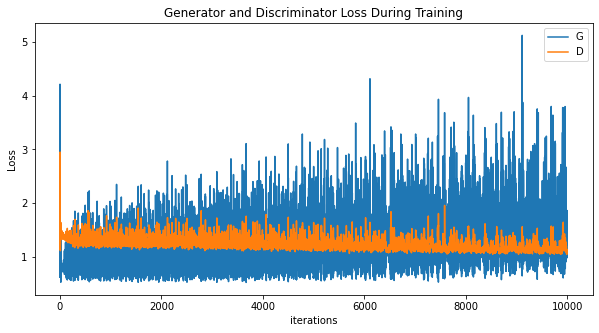

In [91]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Tests

In [94]:
def prediction(W, new_word, k=5):
    x = src_embeddings[src_word2id[new_word]] # embedding on of new_word in the source space
    z = np.dot(W, x) # embedding of the translated word in the target space

    # representation closest to z in the target language space, using cosine similarity as the distance metric
    z_pred1 = np.argmax(cosine_similarity(z.reshape(1,300), tgt_embeddings))

    # top k closest word embeddings in the target space
    z_predk = cosine_similarity(z.reshape(1,300), tgt_embeddings)[0].argsort()[-k:][::-1]
    
    return [tgt_id2word[z_pred1]], [tgt_id2word[z_predk[i]] for i in range(len(z_predk))]  # return the id of the translated word

### Accuracy (%)

In [110]:
# just a litte test
top1, top5 = prediction(W_trained, "bateau", k=5)
print("Top 1 translation for 'bateau' is :", top1)
print("Top 5 translations for 'bateau' are :", top5)

Top 1 translation for 'bateau' is : ['boat']
Top 5 translations for 'bateau' are : ['boat', 'sailing', 'sloop', 'boats', 'ship']


In [130]:
src_words = ['bateau', 'maison', 'argent', 'ordinateur', 'dieu']
tgt_words = []
for i in range(0,len(src_words)):
    top1, top5 = prediction(W_trained.numpy(), src_words[i], k=5) #top 1: english word (target)
    tgt_words.append(top1[0])
    print("FR source:", src_words[i], " | EN top5 traductions:", top5, '\n', '-'*100)

FR source: bateau  | EN top5 traductions: ['boat', 'sailing', 'sloop', 'boats', 'ship'] 
 ----------------------------------------------------------------------------------------------------
FR source: maison  | EN top5 traductions: ['mansion', 'cottage', 'lodge', 'tavern', 'orchard'] 
 ----------------------------------------------------------------------------------------------------
FR source: argent  | EN top5 traductions: ['bronze', 'silver', 'gold', 'gilt', 'money'] 
 ----------------------------------------------------------------------------------------------------
FR source: ordinateur  | EN top5 traductions: ['computer', 'computers', 'workstation', 'workstations', 'desktop'] 
 ----------------------------------------------------------------------------------------------------
FR source: dieu  | EN top5 traductions: ['god', 'gods', 'deity', 'divine', 'blessings'] 
 ----------------------------------------------------------------------------------------------------


In [123]:
# functions of accuracy = 
# - Test how far we are from the "supposed" translation
# compute Wxi find the closest z (SUPPOSED TO BE ITS TRANSLATION) and cumpute eculidian distance
def test_accuracy(X_text, W_trained):
    loss = 0
    for x in X_test : # get all french words
        word2id = {v: k for k, v in src_id2word.items()}
        word_emb_new = np.dot(W_trained, x)
        scores = (tgt_embeddings / np.linalg.norm(tgt_embeddings, 2, 1)[:, None]).dot(word_emb_new / np.linalg.norm(word_emb_new))
        best = scores.argsort()[-1:][::-1]
        nearest_eng_emb = src_embeddings[best]
        loss = loss + np.linalg.norm(word_emb_new-nearest_eng_emb)  
    return(loss)

In [125]:
rand_test_word_id = torch.Tensor(30).random_(nmax).long()
X_test = src_embeddings[rand_test_word_id.numpy()] # GARDER LES MEMES POUR LES TESTS

test_accuracy(X_test,W_trained)

198.87301764840797

In [127]:
# construct a translation French to English dictionary
def prediction_dict(dico, W, k):
    dico_pred1 = {}
    dico_predk = {}
    for word in tqdm(dico.keys()):
        dico_pred1[word], dico_predk[word] = prediction(W, word, k) # lists
    print("Done...")
    return dico_pred1, dico_predk

In [129]:
# k-top accuracy ("acc@k")

dico_pred1, dico_predk = prediction_dict(dico_test, W_trained, k) 

100%|██████████| 1483/1483 [03:49<00:00,  6.47it/s]

Done...


In [131]:
acc1_test, acck_test = accuracy(dico_pred1, dico_predk, dico_test)

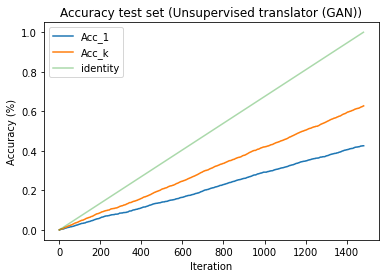

Unsupervised translator (GAN) :
Final accuracy @1 = 42.55 %
Final accuracy @5 = 62.71 %


In [134]:
plt.plot(acc1_test, label="Acc_1")
plt.plot(acck_test,label="Acc_k")
plt.plot([i/len(dico_test) for i in range(len(dico_test))],label="identity",alpha=0.4)
plt.ylabel('Accuracy (%)')
plt.xlabel('Iteration')
plt.title("Accuracy test set (Unsupervised translator (GAN))")
plt.legend()
plt.show()

print("Unsupervised translator (GAN) :")
print("Final accuracy @1 =", round(acc1_test[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test[-1]*100, 2), "%")

In [137]:
print("Best supervised method :")
print("Final accuracy @1 =", round(acc1_test_best[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test_best[-1]*100, 2), "%")
print("")
print("Unsupervised translator (GAN) :")
print("Final accuracy @1 =", round(acc1_test[-1]*100, 2), "%")
print("Final accuracy @5 =", round(acck_test[-1]*100, 2), "%")

Best supervised method :
Final accuracy @1 = 60.22 %
Final accuracy @5 = 77.14 %

Unsupervised translator (GAN) :
Final accuracy @1 = 42.55 %
Final accuracy @5 = 62.71 %


## How to pair words

CSLS tentative

In [ ]:
k = 5 # hyper parameter K-NN
CSLS = np.zeros(nmax)

def CSLS_measure(W, new_word, k):
    x = X_train[src_word2id[new_word]] # embeddings of new_word in the source space
    z = np.dot(W, x).reshape(-1,300) # embeddings of the translated word in the target space
    
    knn = NearestNeighbors(n_neighbors=k, algorithm='auto')
    for t in range(Z_train.shape[0]):
        dist_tgt_nn_z, index_tgt_nn_z = knn.kneighbors(z)
        emb_tgt_nn_z = Z_train[index_tgt_nn_z[0][:]].reshape(-1,300) # embeddings of the k-nn in the tgt space
        r_T = (1/k)*sum(cosine_similarity(z, emb_tgt_nn_z))
        
        dist_tgt_nn_yt, index_tgt_nn_yt = knn.kneighbors(tgt_embeddings[t])
        emb_tgt_nn_yt = Z_train[index_tgt_nn_yt[0][:]].reshape(-1,300) 
        r_S = (1/k)*sum(cosine_similarity(tgt_embeddings[t], emb_tgt_nn_yt))
        
        CSLS[t] = 2*cosine_similarity(z, tgt_embeddings[t]) - r_T - r_S
    CSLS = np.argmax(CSLS)
        
    return CSLS